In [1]:
import sys
import math
import time
import random
sys.path.append("/github/meta_learning/np_variants/")

import torch
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (7.2, 4.8)

c:\Users\dbsxodud\anaconda3\envs\np_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dtype = torch.double
device = torch.device("cuda")

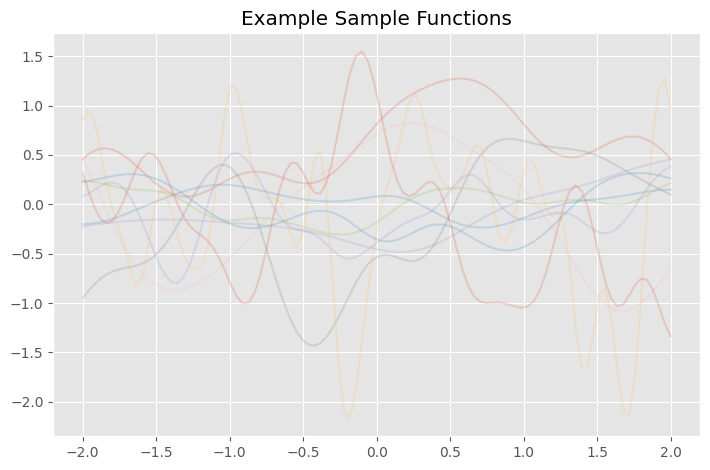

In [3]:
from data.func_generator import GPCurve
from utils import context_target_split

func_generator = GPCurve(kernel="rbf", lb=-2.0, ub=2.0, dtype=dtype, device=device)
batch_x, batch_y = func_generator.sample_for_visualize(batch_size=10, num_samples=100)

for i in range(10):
    plt.plot(batch_x[i].cpu().detach().numpy(), batch_y[i].cpu().detach().numpy(), alpha=0.2)

plt.title("Example Sample Functions")
plt.tight_layout()

In [4]:
from models.np import NeuralProcess
from models.loss_functions import np_loss_func
from utils import context_target_split

In [5]:
lr = 4e-5
batch_size = 100
num_samples = 100
num_epochs = 100000
print_epoch = 10000

num_context_min = 3
num_context_max = 50 - 3
num_target_min = 3
num_target_max = 50

num_train_samples = 4
num_test_samples = 50

In [6]:
model = NeuralProcess(x_dim=1, y_dim=1).to(dtype=dtype, device=device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
loss_func = np_loss_func

In [7]:
start_time = time.time()
for epoch in tqdm(range(num_epochs)):
    x_batch, y_batch = func_generator.sample(batch_size, num_samples, dim=1)

    num_context = random.randint(num_context_min, num_context_max)
    num_extra_target = random.randint(num_target_min, 50 - num_context)

    x_context, y_context, x_target, y_target = context_target_split(x_batch, y_batch, num_context, num_extra_target)

    loss = model(x_context, y_context, x_target, y_target)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if (epoch+1) % print_epoch == 0:
        end_time = time.time()
        print(f"[{epoch+1}/{num_epochs}]\tLoss: {loss.item() / batch_size :.8f}\tTime: {end_time - start_time :.8f}")
        start_time = end_time

  0%|          | 0/100000 [00:00<?, ?it/s]


TypeError: iteration over a 0-d tensor

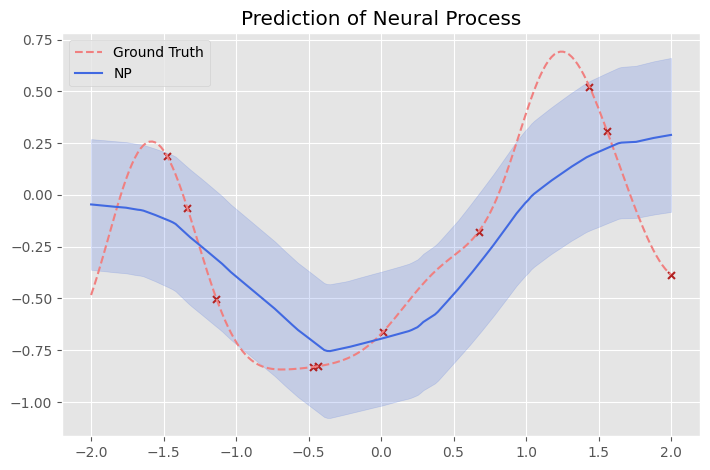

In [ ]:
x_test, y_test = func_generator.sample_for_visualize(batch_size=1, num_samples=200)
x_context, y_context, _, _ = context_target_split(x_test, y_test, num_context=10, num_extra_target=0)

y_pred = model(x_context, y_context, x_test)

plt.scatter(x_context.cpu().detach().numpy().flatten(), y_context.cpu().detach().numpy().flatten(), marker="x", s=25, color="firebrick", zorder=2)
plt.plot(x_test.cpu().detach().numpy().flatten(), y_test.cpu().detach().numpy().flatten(), linestyle="--", color="lightcoral", label="Ground Truth")

plt.plot(x_test.cpu().detach().numpy().flatten(), y_pred.loc.cpu().detach().numpy().flatten(), color="royalblue", label="NP")
plt.fill_between(x_test.cpu().detach().numpy().flatten(), y_pred.loc.cpu().detach().numpy().flatten() - y_pred.scale.cpu().detach().numpy().flatten(),
                                                          y_pred.loc.cpu().detach().numpy().flatten() + y_pred.scale.cpu().detach().numpy().flatten(), color="royalblue", alpha=0.2)

plt.title("Prediction of Neural Process")
plt.legend()
plt.tight_layout()

In [ ]:
torch.save(model.state_dict(), "../models/checkpoints/NP.pt")